# Operational State Identifiation for Aircraft Engines

This notebook analyzes multivariate sensor data from the NASA C-MAPSS turbofan engine dataset to identify latent operational regimes and examine how degradation evolve across system states. 

In [130]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

'C:\\Users\\Charlie'

In [60]:
columns = (
    ["engine_id", "cycle"]
    + [f"op_setting_{i}" for i in range(1, 4)]
    + [f"sensor_{i}" for i in range(1, 22)]
)

In [61]:
train_path = "market-regime-hmm/aerospace/data/train_FD001.txt"

train_df = pd.read_csv(
    "market-regime-hmm/aerospace/data/train_FD001.txt",
    sep=r"\s+",
    header=None,
    names=columns
)

In [62]:
train_df.head()

,engine_id,cycle,op_setting_1,op_setting_2,op_setting_3,sensor_1,sensor_2,sensor_3,sensor_4,sensor_5,...,sensor_12,sensor_13,sensor_14,sensor_15,sensor_16,sensor_17,sensor_18,sensor_19,sensor_20,sensor_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


In [63]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   engine_id     20631 non-null  int64  
 1   cycle         20631 non-null  int64  
 2   op_setting_1  20631 non-null  float64
 3   op_setting_2  20631 non-null  float64
 4   op_setting_3  20631 non-null  float64
 5   sensor_1      20631 non-null  float64
 6   sensor_2      20631 non-null  float64
 7   sensor_3      20631 non-null  float64
 8   sensor_4      20631 non-null  float64
 9   sensor_5      20631 non-null  float64
 10  sensor_6      20631 non-null  float64
 11  sensor_7      20631 non-null  float64
 12  sensor_8      20631 non-null  float64
 13  sensor_9      20631 non-null  float64
 14  sensor_10     20631 non-null  float64
 15  sensor_11     20631 non-null  float64
 16  sensor_12     20631 non-null  float64
 17  sensor_13     20631 non-null  float64
 18  sensor_14     20631 non-nu

In [64]:
drop_sensors = [
    "sensor_1", "sensor_5", "sensor_6",
    "sensor_10", "sensor_16", "sensor_18", "sensor_19"
]
train_df = train_df.drop(columns=drop_sensors)

In [65]:
#Normalize per engine
sensor_cols = [c for c in train_df.columns if "sensor_" in c]

train_norm = train_df.copy()

train_norm[sensor_cols] = (
    train_norm
    .groupby("engine_id")[sensor_cols]
    .transform(lambda x: (x - x.mean()) / x.std())
)

In [66]:
#rolling stats/degredation signals
window = 10

for col in sensor_cols:
    train_norm[f"{col}_roll_mean"] = (
        train_norm
        .groupby("engine_id")[col]
        .transform(lambda x: x.rolling(window).mean())
    )
    train_norm[f"{col}_roll_std"] = (
        train_norm
        .groupby("engine_id")[col]
        .transform(lambda x: x.rolling(window).std())
    )

In [67]:
df_features = train_norm.dropna().reset_index(drop=True)

In [68]:
#select feature set
feature_cols = [
    c for c in df_features.columns
    if "sensor_" in c and ("roll_mean" in c or "roll_std" in c)
]

In [69]:
len(feature_cols)

28

In [70]:
scaler = StandardScaler()
X = scaler.fit_transform(df_features[feature_cols])

In [71]:
#Operational regime identification (HMM)

from hmmlearn.hmm import GaussianHMM

In [72]:
n_regimes = 3

In [73]:
hmm_model = GaussianHMM(
    n_components=n_regimes,
    covariance_type="full",
    n_iter=1000,
    random_state=42
)

In [74]:
hmm_model.fit(X)

,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [75]:
hidden_states = hmm_model.predict(X)

In [76]:
df_regimes = df_features.copy()
df_regimes["regime"] = hidden_states

In [77]:
df_regimes["regime"].value_counts().sort_index()

regime
0     4473
1     4506
2    10752
Name: count, dtype: int64

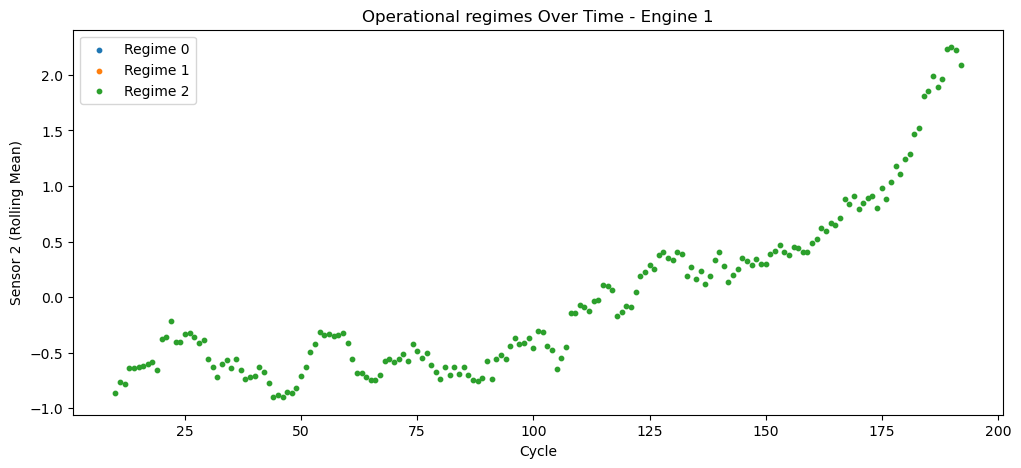

In [78]:
#visualize regimes for a single engine

engine_id = 1
mask = df_regimes[df_regimes["engine_id"] == engine_id]

plt.figure(figsize=(12, 5))

for regime_id in range(n_regimes):
    mask = engine_df["regime"] == regime_id
    plt.scatter(
        engine_df.loc[mask, "cycle"],
        engine_df.loc[mask, "sensor_2_roll_mean"],
        s=10,
        label=f"Regime {regime_id}"
    )


plt.title("Operational regimes Over Time - Engine 1")
plt.xlabel("Cycle")
plt.ylabel("Sensor 2 (Rolling Mean)")
plt.legend()
plt.show()

#confirm regime segmentation aligns with degredation progression

In [79]:
regime_summary = (
    df_regimes
    .groupby("regime")
    .agg(
        mean_cycle=("cycle", "mean"),
        std_cycle=("cycle", "std"),
        obs=("regime", "count")
    )
)

print(regime_summary)

#temporal ordering signal

        mean_cycle  std_cycle    obs
regime                              
0       116.834786  67.131637   4473
1       117.251221  67.297761   4506
2       110.619327  66.101046  10752


In [80]:
transition_matrix = hmm_model.transmat_

transition_df = pd.DataFrame(
    transition_matrix,
    columns=[f"To Regime {i}" for i in range(n_regimes)],
    index=[f"From Regime {i}" for i in range(n_regimes)]
)
print(transition_df)

                To Regime 0   To Regime 1   To Regime 2
From Regime 0  1.729646e-08  1.000000e+00  1.258548e-10
From Regime 1  9.865226e-01  2.085141e-07  1.347716e-02
From Regime 2  2.457244e-03  3.187819e-03  9.943549e-01


In [81]:
# Regime Degredation analysis phase 4


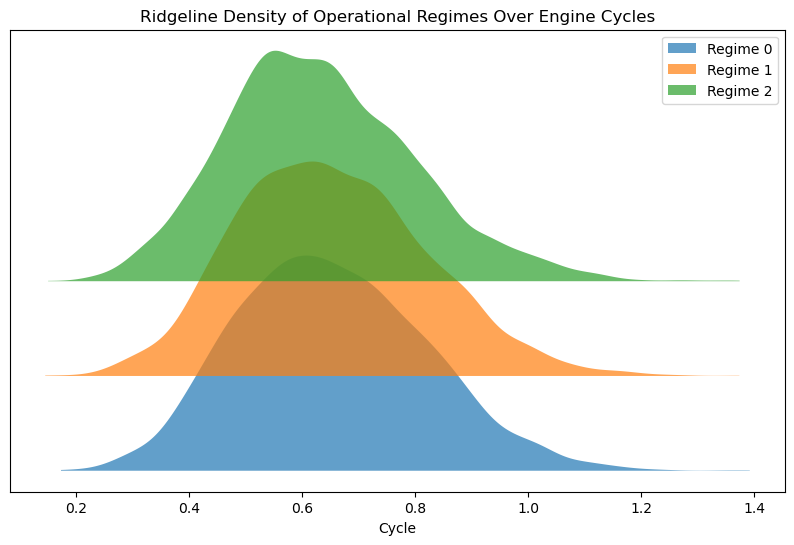

In [82]:
from scipy.stats import gaussian_kde


plt.figure(figsize=(10, 6))

feature = "sensor_2_roll_std"

for i, regime_id in enumerate(sorted(df_regimes["regime"].unique())):
    subset = df_regimes.loc[
        df_regimes["regime"] == regime_id,
        feature
    ].dropna()

    kde = gaussian_kde(subset)
    x_vals = np.linspace(subset.min(), subset.max(), 500)
    y_vals = kde(x_vals)

    plt.fill_between(
        x_vals,
        y_vals + i,
        i,
        alpha=0.7,
        label=f"Regime {regime_id}"
    )
plt.title("Ridgeline Density of Operational Regimes Over Engine Cycles")
plt.xlabel("Cycle")
plt.yticks([])
plt.legend()
plt.show()    

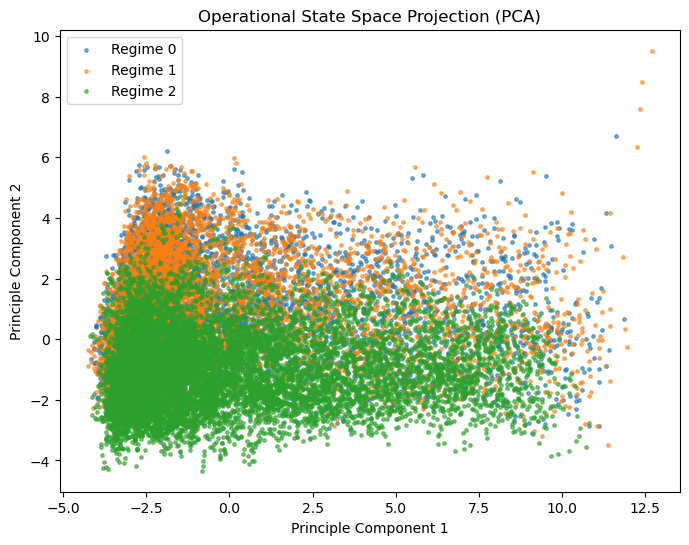

In [83]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

plt.figure(figsize=(8, 6))

for regime_id in range(n_regimes):
    mask = df_regimes["regime"] == regime_id
    plt.scatter(
        X_pca[mask, 0],
        X_pca[mask, 1],
        s=6,
        alpha=0.6,
        label=f"Regime {regime_id}"
    )
plt.title("Operational State Space Projection (PCA)")
plt.xlabel("Principle Component 1")
plt.ylabel("Principle Component 2")
plt.legend()
plt.show()

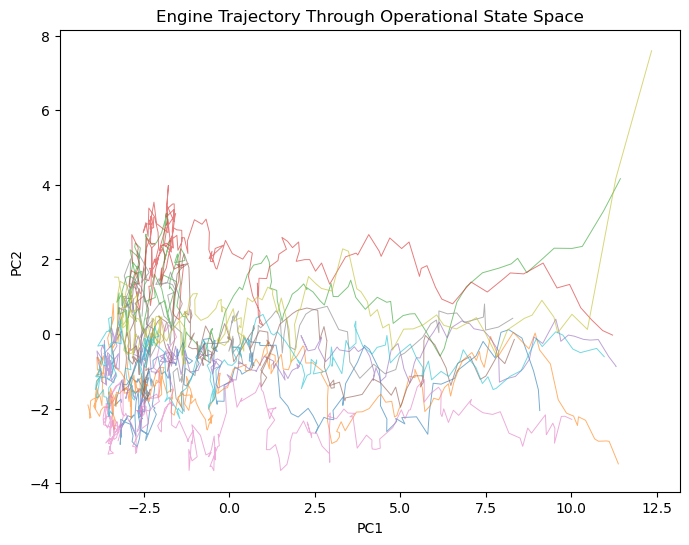

In [84]:
engine_ids = df_regimes["engine_id"].unique()[:10]

plt.figure(figsize=(8, 6))

for engine_id in engine_ids:
    mask = df_regimes["engine_id"] == engine_id
    plt.plot(
        X_pca[mask, 0],
        X_pca[mask, 1],
        linewidth=0.7,
        alpha=0.6
)


plt.title("Engine Trajectory Through Operational State Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()


Individual engines may occupy a single operational regime for most of their lifetime, while regime diversity emerges only when aggregating across the fleet. This reflects the fact that degredation is temporarily localized and not uniformly expressed across engines.

In [87]:
#Regime Dwell Time

df_regimes = df_regimes.sort_values(["engine_id", "cycle"])

In [88]:
df_regimes["regime_change"] = (
    df_regimes["regime"] !=
    df_regimes.groupby("engine_id")["regime"].shift()
)

In [89]:
df_regimes["dwell_id"] = (
    df_regimes.groupby("engine_id")["regime"].cumsum()
)

In [97]:
dwell_times = (
    df_regimes
    .groupby(["engine_id", "regime", "dwell_id"])
    .agg(
        start_cycle=("cycle", "min"),
        end_cycle=("cycle", "max"),
        dwell_length=("cycle", "count")
    )
    .reset_index(drop=True)
)

print(dwell_times.head())

   start_cycle  end_cycle  dwell_length
0           10         10             1
1           11         11             1
2           12         12             1
3           13         13             1
4           14         14             1


In [104]:
dwell_summary = (
    dwell_times
    .groupby(df_regimes["regime"])
    .agg(
        mean_dwell=("dwell_length", "mean"),
        median_dwell=("dwell_length", "median"),
        max_dwell=("dwell_length", "max"),
        n_segments=("dwell_length", "count")
    )
)

print(dwell_summary)

        mean_dwell  median_dwell  max_dwell  n_segments
regime                                                 
0              1.0           1.0          1        4473
1              1.0           1.0          1        4506
2              1.0           1.0          1       10752


In [105]:
#Distance-to-Degraded Regime
regime_order = (
    df_regimes
    .groupby("regime")["cycle"]
    .mean()
    .sort_values()
)
regime_order

regime
2    110.619327
0    116.834786
1    117.251221
Name: cycle, dtype: float64

The regime with the highest mean cycle is the degraded regime

In [106]:
degraded_regime = regime_order.index[-1]

In [107]:
#Regme Centroids in PCA space

centroids = (
    pd.DataFrame(X_pca, columns=["PC1", "PC2"])
    .assign(regime=df_regimes["regime"])
    .groupby("regime")
    .mean()
)

Define distance-to-degraded-regime
for every point: d(x) = ||x - µdegraded||

In [108]:
from numpy.linalg import norm

In [109]:
degraded_centroid = centroids.loc[degraded_regime].values

df_regimes["dist_to_degraded"] = norm(
    X_pca - degraded_centroid,
    axis=1
)

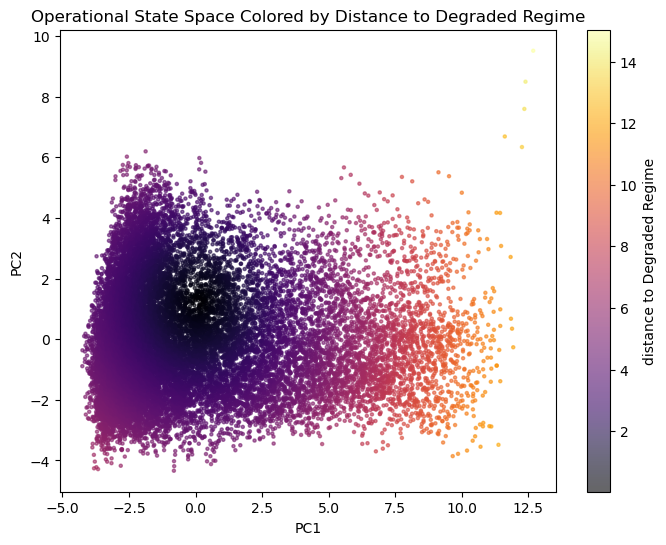

In [111]:
plt.figure(figsize(8, 6))

sc = plt.scatter(
    X_pca[:, 0],
    X_pca[:, 1],
    c=df_regimes["dist_to_degraded"],
    cmap="inferno",
    s=5,
    alpha=0.6
)

plt.colorbar(sc, label="distance to Degraded Regime")
plt.title("Operational State Space Colored by Distance to Degraded Regime")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

In [112]:
#Compute True RUL

max_cycles = (
    df_regimes
    .groupby("engine_id")["cycle"]
    .max()
    .rename("max_cycle")
)

df_regimes = df_regimes.join(max_cycles, on="engine_id")
df_regimes["RUL"] = df_regimes["max_cycle"] - df_regimes["c"]

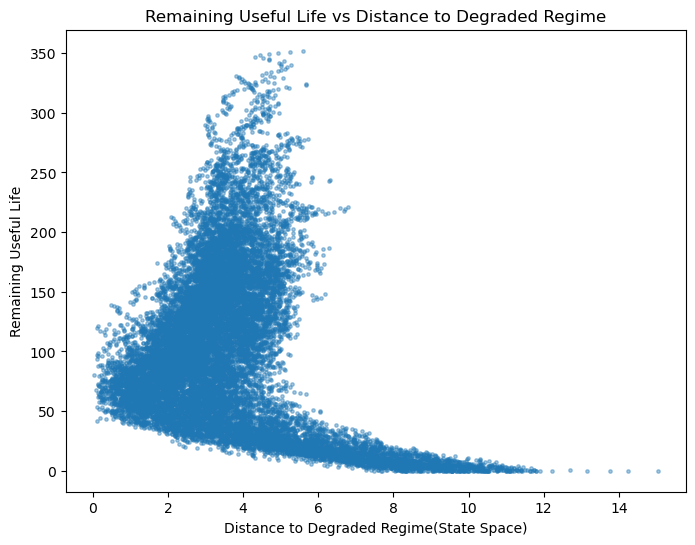

In [113]:
#RUL vs Distance-To-Degraded
plt.figure(figsize=(8,6))

plt.scatter(
    df_regimes["dist_to_degraded"],
    df_regimes["RUL"],
    s=6,
    alpha=0.4
)

plt.title("Remaining Useful Life vs Distance to Degraded Regime")
plt.xlabel("Distance to Degraded Regime(State Space)")
plt.ylabel("Remaining Useful Life")
plt.show()

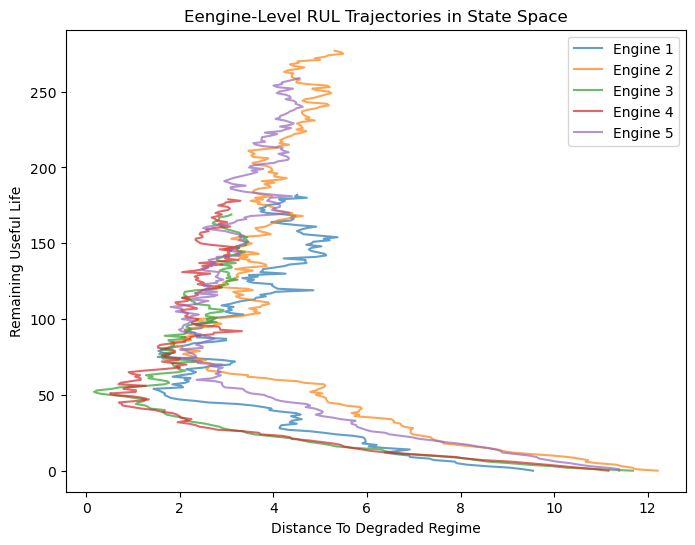

In [115]:
#Engine Level Trajectories
engine_ids = df_regimes["engine_id"].unique()[:5]

plt.figure(figsize=(8,6))

for engine_id in engine_ids:
    e = df_regimes[df_regimes["engine_id"] == engine_id]
    plt.plot(
        e["dist_to_degraded"],
        e["RUL"],
        linewidth=1.5,
        alpha=0.7,
        label=f"Engine {engine_id}"
    )

plt.title("Eengine-Level RUL Trajectories in State Space")
plt.xlabel("Distance To Degraded Regime")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.show()

In [117]:
#Spearman Correlation

from scipy.stats import spearmanr

rho, pval = spearmanr(
    df_regimes["dist_to_degraded"],
    df_regimes["RUL"]
)

print(f"Spearman rho: {rho:.3f}, p-value: {pval:.3e}")

Spearman rho: -0.130, p-value: 2.402e-75


- strong negative rho - distance encodes degradation
- significance confirms it's not noise


In [123]:
from sklearn.linear_model import LinearRegression

X_rul = df_regimes[["dist_to_degraded"]]
y_rul = df_regimes["RUL"]

model = LinearRegression()
model.fit(X_rul, y_rul)

print("Intercept", model.intercept_)
print("Slope", model.coef_[0])

Intercept 135.69351279779085
Slope -8.793126212671506


C:\Users\Charlie\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2691: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


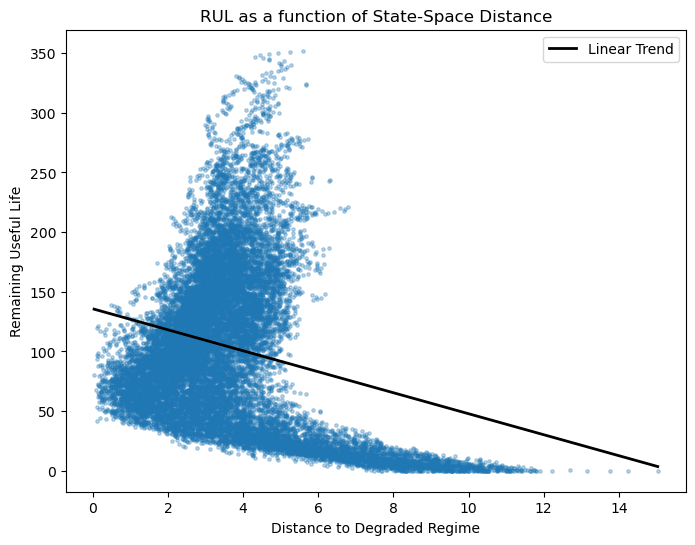

In [129]:
plt.figure(figsize=(8,6))

plt.scatter(
    df_regimes["dist_to_degraded"],
    df_regimes["RUL"],
    s=6,
    alpha=0.3
)

x_vals = np.linspace(
    df_regimes["dist_to_degraded"].min(),
    df_regimes["dist_to_degraded"].max(),
    100
)

plt.plot(
    x_vals,
    model.predict(x_vals.reshape(-1,1)),
    color="Black",
    linewidth=2,
    label="Linear Trend"
)

plt.title("RUL as a function of State-Space Distance")
plt.xlabel("Distance to Degraded Regime")
plt.ylabel("Remaining Useful Life")
plt.legend()
plt.show()

## Linking Operational State Space To Remaining Useful Life

- RUL decreases as trajectories approacg rge degredaded region of state space
- Distance-to-degraded provides a continuous health indicator
- The relationship is monotonic but nonlinear and heteroskedatic
- This framing avoids hard failure thresholds and preserves system continuity 